In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter

In [2]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [4]:
cii_map = m_cii.maps

## Stellar Mass / Halo mass / SFR relationships

Dongwoo's code for Behroozi+2013 implementation of Stellar mass:

In [6]:
a = lambda z:1/(1.+z)
# Behroozi et al 2013a parameters
nu = lambda z:np.exp(-4*a(z)**2)
log10_eps = lambda z:-1.777-0.006*(a(z)-1)*nu(z)-0.119*(a(z)-1)
log10_M1 = lambda z:11.514+(-1.793*(a(z)-1)-0.251*z)*nu(z)
alpha = lambda z:-1.412+0.731*(a(z)-1)*nu(z)
delta = lambda z:3.508+(2.608*(a(z)-1)-0.043*z)*nu(z)
gamma = lambda z:0.316+(1.319*(a(z)-1)+0.279*z)*nu(z)
f = lambda x,z:-np.log10(10**(alpha(z)*x)+1)+delta(z)*(np.log10(1+np.exp(x)))**gamma(z)/(1+np.exp(10**(-x)))
xi = lambda z:0.218-0.023*(a(z)-1)

def stellar_m(halo_m,z,scatter=True):
    sm = 10**(log10_eps(z)+log10_M1(z)+f(np.log10(halo_m/(10**log10_M1(z))),z)-f
(0,z))
    if scatter:
        rand = np.random.lognormal(-0.5*(xi(z)*np.log(10))**2,xi(z)*np.log(10))
        return sm*rand
    else:
        return sm

In [7]:
halo_ms = m_cii.halos.M

In [58]:
halo_zs = m_cii.halos.redshift

In [11]:
map_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1
med_z = np.median(map_zs)

In [12]:
halo_sm = stellar_m(halo_ms, med_z)

Loading SFR:

In [14]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

In [15]:
tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/tables/sfr_behroozi_release.dat'

In [18]:
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [62]:
halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

Text(0, 0.5, 'SFR')

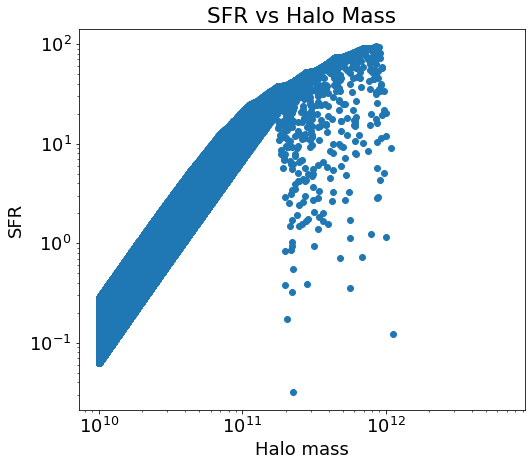

In [65]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

Metallicity implementation:

In [66]:
gamma = 0.31
beta = 2.1
m_0 = 10.11
m_1 = 0.56
Z_0 = 8.779

In [68]:
def M_0(sfr):
    return (10**(m_0))*(sfr**(m_1))

In [69]:
halo_M0 = M_0(halo_sfr)

In [71]:
def metal(stellar_m, M_0):
    return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))

In [72]:
halo_z = metal(halo_sm, halo_M0)

/tmp/ipykernel_2926842/140302558.py:2: RuntimeWarning: divide by zero encountered in divide
  return Z_0 - (gamma/beta)*np.log10(1 + (stellar_m/M_0)**(-beta))


Text(0, 0.5, 'Halo Metallicity')

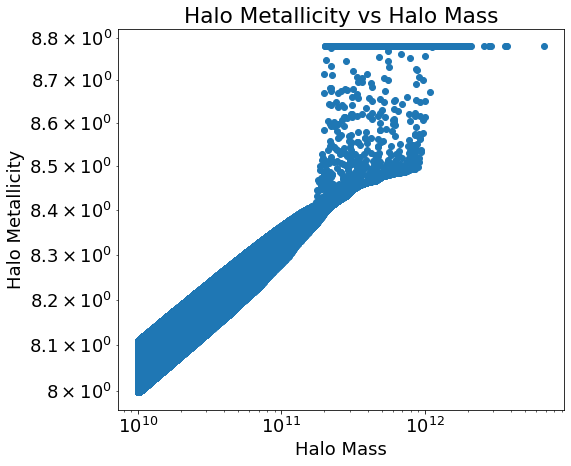

In [76]:
plt.scatter(halo_ms, halo_z)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')

Text(0, 0.5, 'Halo Stellar Mass')

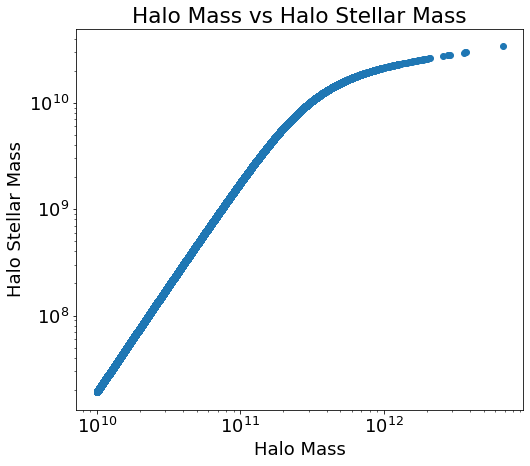

In [77]:
plt.scatter(halo_ms, halo_sm)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Mass vs Halo Stellar Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Stellar Mass')

In [78]:
sfr_0 = 1
logsfr_0 = np.log10(sfr_0)

In [79]:
m_range = np.logspace(8, 12, 1000)

In [80]:
M_0_0 = M_0(sfr_0)

In [81]:
z_0 = metal(m_range, M_0_0)

Text(0, 0.5, 'Halo Metallicity')

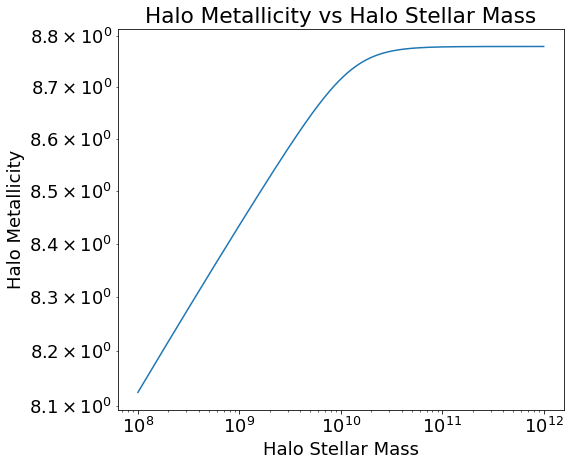

In [82]:
plt.plot(m_range, z_0)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Stellar Mass')
plt.xlabel('Halo Stellar Mass')
plt.ylabel('Halo Metallicity')

In [83]:
sm_0 = 10**9
logsm_0 = np.log10(sm_0)

In [84]:
sfr_range = np.logspace(-2, 2, 1000)

In [85]:
M_0_1 = M_0(sfr_range)

In [86]:
z_1 = metal(sm_0, M_0_1)

Text(0, 0.5, 'Halo Metallicity')

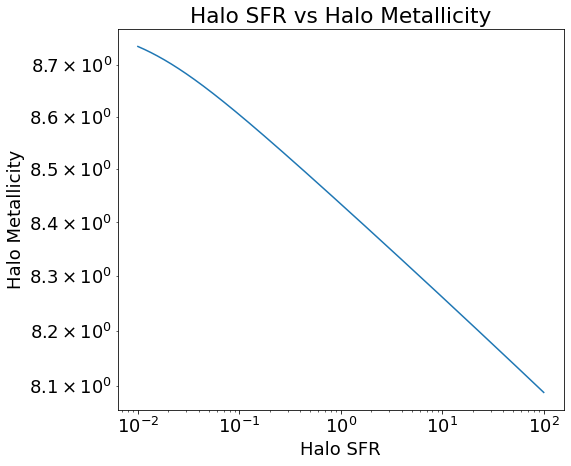

In [87]:
plt.plot(sfr_range, z_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo SFR vs Halo Metallicity')
plt.xlabel('Halo SFR')
plt.ylabel('Halo Metallicity')

## Halo Cut Off

In [88]:
from limlam_mocker import limlam_mocker as llm
import scipy as sp
import scipy.interpolate
sigma_sfr = 0.3

In [89]:
tablepath = '/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2/limlam_mocker/tables/sfr_behroozi_release.dat'

In [90]:
dat_zp1, dat_logm, dat_logsfr, _ = np.loadtxt(tablepath, unpack=True)
dat_logzp1 = np.log10(dat_zp1)
dat_sfr    = 10.**dat_logsfr
dat_logzp1  = np.unique(dat_logzp1)    # log(z), 1D 
dat_logm    = np.unique(dat_logm)      # log(Mhalo), 1D        
dat_sfr     = np.reshape(dat_sfr, (dat_logm.size, dat_logzp1.size))
dat_logsfr  = np.reshape(dat_logsfr, dat_sfr.shape)

In [91]:
from scipy.interpolate import SmoothBivariateSpline
dat_logzp1_,dat_logm_ = np.meshgrid(dat_logzp1,dat_logm)
badspl = SmoothBivariateSpline(dat_logzp1_[-1000<(dat_logsfr)],dat_logm_[-1000<(dat_logsfr)],dat_logsfr[-1000<(dat_logsfr)],kx=4,ky=4)
dat_sfr[dat_logsfr==-1000.] = 10**badspl(dat_logzp1,dat_logm).T[dat_logsfr==-1000.]
        
# Get interpolated SFR value(s)    
sfr_interp_tab = sp.interpolate.RectBivariateSpline(dat_logm, dat_logzp1, dat_sfr, kx=1, ky=1)

In [92]:
halo_sfr = sfr_interp_tab.ev(np.log10(halo_ms), np.log10(halo_zs + 1))

Text(0, 0.5, 'SFR')

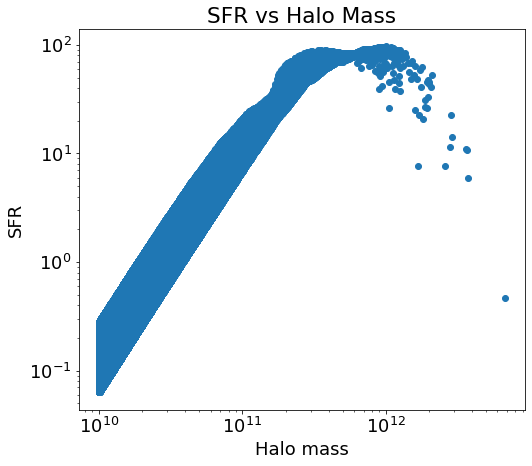

In [93]:
plt.scatter(halo_ms, halo_sfr)
plt.xscale('log')
plt.yscale('log')
plt.title('SFR vs Halo Mass')
plt.xlabel('Halo mass')
plt.ylabel('SFR')

In [94]:
halo_M0 = M_0(halo_sfr)

In [95]:
halo_z = metal(halo_sm, halo_M0)

Text(0, 0.5, 'Halo Metallicity')

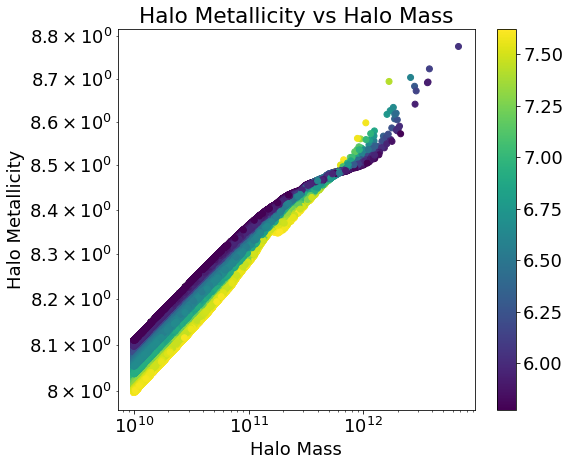

In [98]:
plt.scatter(halo_ms, halo_z, c = halo_zs)
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.title('Halo Metallicity vs Halo Mass')
plt.xlabel('Halo Mass')
plt.ylabel('Halo Metallicity')

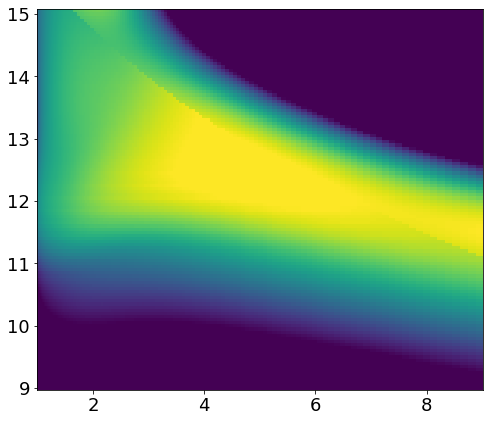

In [111]:
# DTC driving for a bit ...
plt.pcolormesh(10**dat_logzp1,dat_logm,np.log10(dat_sfr),vmin=-2,vmax=2)

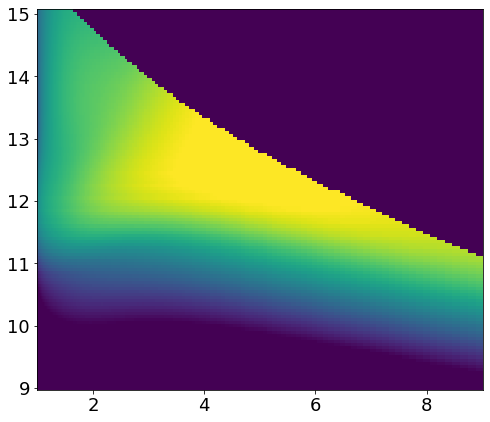

In [112]:
plt.pcolormesh(10**dat_logzp1,dat_logm,dat_logsfr,vmin=-2,vmax=2)

In [117]:
_,_,_,dat_log_sm_med = np.loadtxt(tablepath, unpack=True)

In [118]:
dat_log_sm_med

array([ 5.841552,  5.842527,  5.843247, ..., 10.726083, 10.712571,
       10.698079])

In [123]:
tuple(zip(10**dat_logzp1_.flatten(),dat_logm_.flatten(),np.log10(dat_sfr).flatten(),dat_log_sm_med))[:10]

((1.0, 9.0, -4.109195, 5.841552),
 (1.016249, 9.0, -4.041178, 5.842527),
 (1.032761, 9.0, -3.969078, 5.843247),
 (1.049542, 9.0, -3.910695, 5.843692),
 (1.066596, 9.0, -3.862484, 5.843835),
 (1.083927, 9.0, -3.823168, 5.843649),
 (1.101539, 9.0, -3.789299, 5.843096),
 (1.119438, 9.0, -3.759242, 5.842162),
 (1.137627, 9.0, -3.732249, 5.840821),
 (1.156112, 9.0, -3.708302, 5.839025))

In [121]:
# let's rewrite the table file somewhere else ...

In [122]:
%pwd

'/cita/h/home-2/horlaville/clara_limlam/limCode2020-master_clara_2'

In [125]:
with open('sfr_reinterp.dat','w') as f:
    f.write('#(1+z) Log10(Halo Mass) Log10(<SFR>) Log10(Median SM)\r\n')
    f.write('#Units are Msun, Msun/yr, and Msun, respectively.\r\n')
    f.write('#(includes crude extrapolation into unphysical halo mass ranges)\r\n')
    for dat_tuple in zip(10**dat_logzp1_.flatten(),dat_logm_.flatten(),np.log10(dat_sfr).flatten(),dat_log_sm_med):
        f.write('{:.6f} {:.6f} {:.6f} {:.6f}\r\n'.format(*dat_tuple))

In [131]:
m_cii.z

<Quantity 6.588>

In [132]:
np.mean(map_zs)

6.624655345621224

## Metallicity Cube

In [134]:
def metal(ps_m):
    return 10**(ps_m - 8.69)

In [135]:
real_Z = metal(halo_z)

In [137]:
bins3D = [m_cii.mapinst.pix_binedges_x, m_cii.mapinst.pix_binedges_y, m_cii.mapinst.nu_binedges[::-1]]

In [138]:
n_halos, _ = np.histogramdd( np.c_[m_cii.halos.ra, m_cii.halos.dec, m_cii.halos.nu], 
                                  bins    = bins3D)

In [140]:
tot_met, _ = np.histogramdd( np.c_[m_cii.halos.ra, m_cii.halos.dec, m_cii.halos.nu], 
                                  bins    = bins3D, weights = real_Z)

In [141]:
avg_met = tot_met/n_halos
avg_met = avg_met[:,:,::-1]

/tmp/ipykernel_2926842/499547231.py:1: RuntimeWarning: invalid value encountered in divide
  avg_met = tot_met/n_halos


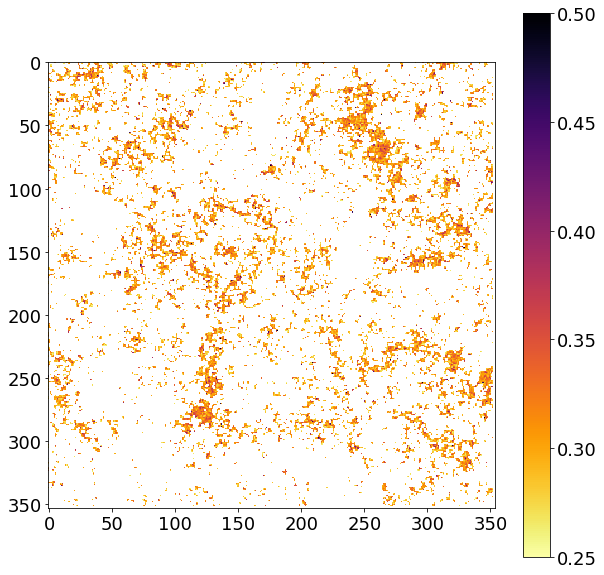

In [163]:
plt.figure(figsize=(10,10))
plt.imshow(avg_met[:, :, 3], cmap=plt.cm.inferno_r, vmin=0.25, vmax=0.5)
plt.colorbar()